# HPO問題のELA特徴量
https://hackmd.io/Rvu-VhbbRJqyzE9MZpoExQ#TODO11

## Dataset
- wilt
- ada
- analcatdata_dmft
- bank-marketing
- cylinder-bands

## algorithm
- XGBoost
- lightgbm
- randomforest

## parameter
- {eta}
- {eta, gamma}
- {eta, gamma, lambda}
- {eta, gamma, lambda, alpha}


## パラメータのデフォルト値
### lightgbm
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- eta: 0.1
- gamma: 0.0
- lambda: 0.0
- alpha: 0.0

### XGBoost
https://qiita.com/m_yama123/items/133e5b73b2e2bcd6bd6a
- eta: 0.3
- gamma: 0.0
- lambda: 1.0
- alpha: 0.0


In [1]:
import os
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import cross_val_score

from pflacco.classical_ela_features import *
from pflacco.sampling import create_initial_sample

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

from preprocess_data import preprocess_data
from algorithm import get_params, lgbm_model, xgb_model, rf_model


c:\Users\kyana\OneDrive\ドキュメント\Github\HPO_ELA\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    "exp_num": "01",
    "data_name": "wilt", #"wilt", "ada", "analcatdata_dmft", "bank-marketing", "cylinder-bands"
    "algorithm": "XGB", # "lgbm", "XGB", "RandamForest"
    "num_parms": "4", # 1, 2, 3, 4
    "metrics": "logloss", # "logloss"
}

output_path = f"../output/{config['exp_num']}_{config['data_name']}×{config['algorithm']}×{config['num_parms']}×{config['metrics']}"
os.mkdir(output_path)

In [3]:
# データセットの読み込みと前処理
data = preprocess_data(config["data_name"])
X, y = data.get_X_y()

In [4]:
X

,V1,V2,V3,V4,V5
0,120.362774,205.500000,119.395349,416.581395,20.676318
1,124.739583,202.800000,115.333333,354.333333,16.707151
2,134.691964,199.285714,116.857143,477.857143,22.496712
3,127.946309,178.368421,92.368421,278.473684,14.977453
4,135.431548,197.000000,112.690476,532.952381,17.604193
...,...,...,...,...,...
4834,123.554348,202.826087,106.391304,364.565217,17.314068
4835,121.549028,276.220000,175.593333,402.620000,13.394574
4836,119.076687,247.951220,113.365854,808.024390,24.830059
4837,107.944444,197.000000,90.000000,451.000000,8.214887


In [5]:
y.value_counts()

Class
0    4578
1     261
Name: count, dtype: int64

In [6]:
# ハイパーパラメータの探索範囲
param_bounds = get_params(config["num_parms"])
param_bounds


{'eta': [0.0009118819655545162, 1.0],
 'gamma': [4.5399929762484854e-05, 7.38905609893065],
 'lambda': [0.0009118819655545162, 1096.6331584284585],
 'alpha': [0.0009118819655545162, 1096.6331584284585]}

In [7]:
# ハイパーパラメータ空間をサンプリング
n_samples = 1000  # 必要に応じて変更
samples = {param: np.random.uniform(low=low, high=high, size=n_samples)
           for param, (low, high) in param_bounds.items()}
samples = pd.DataFrame(samples)
samples

,eta,gamma,lambda,alpha
0,0.628146,6.071391,516.249591,1058.388756
1,0.120099,5.007992,407.459424,816.985641
2,0.291802,1.852166,635.077683,1095.449323
3,0.873658,6.700316,668.614660,754.313846
4,0.071934,6.899308,794.451301,923.642635
...,...,...,...,...
995,0.847835,3.118454,0.538596,48.991927
996,0.833744,0.036320,466.989941,703.352543
997,0.010676,6.098795,1062.789395,443.069385
998,0.193663,4.262042,920.186691,414.702477


In [8]:
# 各ハイパーパラメータ設定に対する目的関数を計算
def objective(params):
    # print(params)
    match config["algorithm"]:
        case "lgbm":
            model = lgbm_model(config["num_parms"], params)
        case "XGB":
            model = xgb_model(config["num_parms"], params)
        case "RandamForest":
            model = rf_model(config["num_parms"], params)

    # 10-fold CVスコア
    score = cross_val_score(model, X, y, cv=10, scoring='neg_log_loss').mean()
    # print(score)
    return score

# 目的関数の値を計算
# samples_y = samples.apply(objective, axis=1)
samples_y = samples.progress_apply(objective, axis=1)

100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


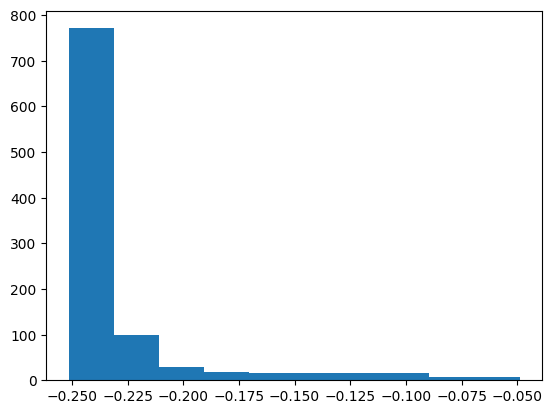

In [9]:
plt.hist(samples_y)
plt.savefig(f"{output_path}/histgram.png") 
plt.show()

In [10]:
sample_df = pd.concat([samples, samples_y], axis=1)
sample_df.columns = list(param_bounds.keys()) + ["score"]
sample_df

,eta,gamma,lambda,alpha,score
0,0.628146,6.071391,516.249591,1058.388756,-0.251463
1,0.120099,5.007992,407.459424,816.985641,-0.251463
2,0.291802,1.852166,635.077683,1095.449323,-0.251463
3,0.873658,6.700316,668.614660,754.313846,-0.251463
4,0.071934,6.899308,794.451301,923.642635,-0.251463
...,...,...,...,...,...
995,0.847835,3.118454,0.538596,48.991927,-0.109700
996,0.833744,0.036320,466.989941,703.352543,-0.251463
997,0.010676,6.098795,1062.789395,443.069385,-0.251463
998,0.193663,4.262042,920.186691,414.702477,-0.251463


In [11]:
# ELA特徴量を計算します
ela_meta = calculate_ela_meta(samples, samples_y)
ela_distr = calculate_ela_distribution(samples, samples_y)
# ela_level = calculate_ela_level(samples, samples_y)
nbc = calculate_nbc(samples, samples_y)
disp = calculate_dispersion(samples, samples_y)
ic = calculate_information_content(samples, samples_y, seed=100)

In [12]:
# Store results in pandas dataframe
features_hpo = pd.DataFrame({**ic, **ela_meta, **ela_distr, **nbc, **disp}, index = [0])
features_hpo

,ic.h_max,ic.eps_s,ic.eps_max,ic.eps_ratio,ic.m0,ic.costs_runtime,ela_meta.lin_simple.adj_r2,ela_meta.lin_simple.intercept,ela_meta.lin_simple.coef.min,ela_meta.lin_simple.coef.max,...,disp.ratio_median_25,disp.diff_mean_02,disp.diff_mean_05,disp.diff_mean_10,disp.diff_mean_25,disp.diff_median_02,disp.diff_median_05,disp.diff_median_10,disp.diff_median_25,disp.costs_runtime
0,0.40645,-2.617618,0.00011,-3.798799,0.142285,0.578,0.440349,-0.187839,5.083354e-07,0.001026,...,0.80438,-102.568821,-102.568821,-102.568821,-102.568821,-109.738485,-109.738485,-109.738485,-109.738485,0.078


In [13]:
features_hpo.to_csv(f"{output_path}/ela_features.csv", index=False)